# Convert Ensemble to Function Automatically.

## Preliminaries

### Imports

In [1]:
import os
import pandas as pd
import sys
import networkx as nx

from os.path import dirname
from networkx.drawing.nx_pydot import to_pydot

note_dir = os.getcwd()

root_dir = dirname(note_dir)
src_dir = os.path.join(root_dir, "src")

sys.path.append(src_dir)

import morpheus
from morpheus.core import compose
from morpheus.tests import default_chain, default_ensemble, default_dataset
from morpheus.graph import (model_to_graph,
                            model_graph_traces,
                            model_graph_layout, 
                            convert_positions_to_dot_format,
                           add_merge_nodes)

In [2]:
from functools import partial

In [3]:
# In Greek to avoid nameclashes
ω = compose.o
χ = compose.x

### Functions

In [4]:
def fix_layout(G):
    
    for n in G.nodes():
        node = G.nodes(data=True)[n]
        if node['bipartite'] == 'func':
            node['shape'] = "\"square\""
            node['width'] = "2"
        elif node['bipartite'] == 'data':
            node['shape'] = "\"circle\""
        else:
            pass
    
    return G

### Ensemble

In [5]:
data, _ = default_dataset(random_state=16)
e = default_ensemble(random_state=16)


        Learning model with desc ids:    [0, 1, 2]
                            targ ids:    [5]
        

        Learning model with desc ids:    [0, 1, 3]
                            targ ids:    [4, 5]
        


In [6]:
data.values.shape

(800, 8)

In [7]:
data[0]

0     -1.801472
1      3.351491
2     -0.530436
3      0.200015
4      1.567603
5     -0.537100
6      1.703616
7     -1.989907
8      2.529724
9     -4.339198
10    -1.622942
11    -2.163636
12    -3.559023
13    -2.819993
14    -0.075448
15    -0.759716
16    -1.212780
17    -0.641635
18    -0.148629
19    -2.738697
20     1.111651
21    -1.515754
22    -1.683190
23    -0.098119
24    -3.424989
25     0.296468
26    -3.821517
27    -1.411153
28    -0.083779
29    -2.658860
         ...   
770    0.782764
771    0.666557
772   -3.200410
773   -3.325568
774   -1.586084
775   -0.962362
776    1.380212
777   -0.693417
778    0.656995
779   -1.703296
780   -4.609208
781   -0.749221
782    1.814082
783   -4.889654
784   -2.968182
785   -1.446919
786    0.679935
787   -0.876681
788    2.133597
789   -0.496812
790    1.303194
791    0.093866
792   -3.061835
793    2.524427
794    0.593079
795    0.217192
796    0.825435
797   -1.855964
798   -2.098206
799    1.173136
Name: 0, Length: 800, dt

In [8]:
e.pretty_print()


        # Main
        Descriptive attributes:     [0. 1. 2. 3.]
        Target attributes:          [4. 5.]

        ## On types (mostly nominals)
        Target attribute types:                     ['numeric', 'numeric']
        N_classes of nominal target attributes:     []
        Classes of nominal target attributes:       []

        ## Weights
        Total weights of target attributes:         [1. 2.]

         
        ## Estimators
        Estimators used:        ['RandomForestRegressor', 'RandomForestRegressor']
        N_estimators:           2
        


## Conversion

In [9]:
model_one = e.estimators_[0]
model_two = e.estimators_[1]

In [10]:
G_one = model_to_graph(model_one, idx=1)
G_two = model_to_graph(model_two, idx=2)

In [11]:
G = nx.compose(G_one, G_two)

In [12]:
G = fix_layout(G)

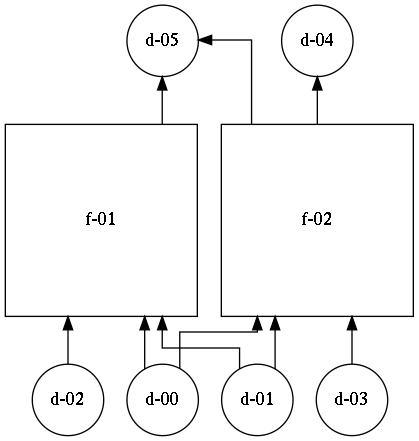

In [13]:
X = to_pydot(G)
X.set('rankdir', 'BT')
X.set('splines', 'ortho')

with open("test.dot", "w") as text_file:
    print(X.to_string(), file=text_file)
    
!dot -T png test.dot > test.png  # Bash command

from IPython.display import Image, display
from IPython.core.display import HTML 

display(Image('test.png', unconfined=True))

In [14]:
add_merge_nodes(G)

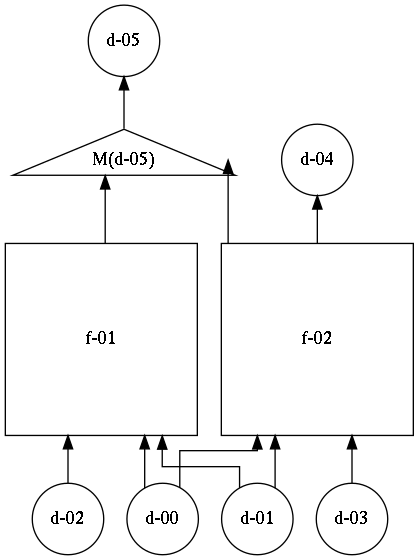

In [15]:
X = to_pydot(G)
X.set('rankdir', 'BT')
X.set('splines', 'ortho')

with open("test.dot", "w") as text_file:
    print(X.to_string(), file=text_file)
    
!dot -T png test.dot > test.png  # Bash command

from IPython.display import Image, display
from IPython.core.display import HTML 

display(Image('test.png', unconfined=True))

In [16]:
import numpy as np

def select(idx):
    
    def select(X):
        if len(X.shape) > 1:
            return X[:, idx]
        elif len(X.shape) == 1:
            assert idx == 0
            return X
    return select

In [17]:
# Convert the graph to its functions
sorted_list = list(nx.topological_sort(G))
print(sorted_list)
functions = {}
for node_name in sorted_list:
    node = G.nodes(data=True)[node_name]
    #print(node)
    if node.get('kind', None) == 'data': 
        if len(nx.ancestors(G, node_name)) == 0:
            functions[node_name] = select(node['idx'])
        elif len(nx.descendants(G, node_name)) == 0:
            functions[node_name] = 'end'
            
    elif node.get('kind', None) == 'model':
        
        previous_nodes = [t[0] for t in G.in_edges(node_name)]
        
        inputs = [functions[n] for n in previous_nodes]
        inputs = ω(np.transpose, χ(*inputs, return_type=np.array))
        f = node['function']
        functions[node_name] = ω(f, inputs)
    
    elif node.get('kind', None) == 'merge':
        merge_idx = node['idx']
        previous_nodes = [t[0] for t in G.in_edges(node_name)]
        previous_t_idx = [G.nodes()[n]['tgt'] for n in previous_nodes]
        print(previous_t_idx)
        inputs = [(functions[n],t) for n, t in zip(previous_nodes, previous_t_idx)]
        
        inputs = [ω(select(t_idx.index(merge_idx)), f) for f, t_idx in inputs]
        inputs = ω(np.transpose, χ(*inputs, return_type=np.array))
        
        f = partial(np.mean, axis=1)
        functions[node_name] = ω(f, inputs)

['d-03', 'd-02', 'd-01', 'd-00', 'f-02', 'd-04', 'f-01', 'M(d-05)', 'd-05']
[[5], [4, 5]]


In [18]:
functions

{'d-03': <function __main__.select.<locals>.select(X)>,
 'd-02': <function __main__.select.<locals>.select(X)>,
 'd-01': <function __main__.select.<locals>.select(X)>,
 'd-00': <function __main__.select.<locals>.select(X)>,
 'f-02': <function morpheus.core.compose.o.<locals>.sequential_composition(*function_arguments)>,
 'd-04': 'end',
 'f-01': <function morpheus.core.compose.o.<locals>.sequential_composition(*function_arguments)>,
 'M(d-05)': <function morpheus.core.compose.o.<locals>.sequential_composition(*function_arguments)>,
 'd-05': 'end'}

In [22]:
res = functions['M(d-05)'](data.values)


In [25]:
res.shape

(800,)

In [26]:
res

array([ 3.75393730e-01,  7.01912049e-01,  1.91488824e-01,  5.63511324e-01,
        5.32511972e-01,  8.00357704e-01,  6.78442833e-01, -5.59073165e-01,
        3.21785614e-02, -2.00142688e+00, -2.48780375e-01, -1.61227130e+00,
       -6.87784048e-01, -2.46574371e+00,  1.19858437e+00,  4.46355773e-01,
       -3.23632741e-01,  1.00045521e+00,  1.51353190e-01, -6.97042443e-01,
        4.61196627e-01,  5.42070156e-01, -7.86737283e-03,  8.80941310e-01,
        9.49113714e-01,  8.29259764e-01, -3.75475954e+00, -7.95716316e-01,
        1.47222844e+00, -1.67154628e+00,  6.49417903e-01,  1.35692871e-01,
       -3.93460249e+00, -2.13993537e+00,  6.02537303e-01,  6.54414190e-01,
       -1.61353074e-02,  5.19315121e-03,  3.18779721e-01, -1.80243558e+00,
        1.29589546e+00, -1.19309932e+00,  4.38561340e-01,  1.89022776e+00,
       -5.03100874e-01, -1.15754600e-01,  1.12100319e-01,  8.14863379e-01,
        3.94503674e-01,  7.49774601e-01,  1.14012666e-01,  2.77075293e-01,
        4.82668794e-01,  

In [ ]:
functions['f-01'](data.values)

In [ ]:
functions['f-02'](data.values)